In [1]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
import time
import os
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from rdkit import Chem
from rdkit.Chem import Descriptors, QED
from rdkit.Chem import Draw
from IPython.display import display
import selfies as sf
import time

In [2]:
# --- Configuration ---
N_MOLECS = 8000
BATCH_SIZE = 64 # Classical models handle larger batches easily
EMBED_DIM = 32  
HIDDEN_DIM = 128 # Standard GRU size
N_EPOCHS = 200

# Load Metadata
with open(f"../data/metadata_selfies_{N_MOLECS}.json", "r") as f:
    metadata = json.load(f)

VOCABULARY_SIZE = metadata['vocabulary_size']
MAX_LEN = metadata['max_sequence_length']
ALPHABET = metadata['alphabet']
BITS_PER_TOKEN = metadata['bits_per_token']
min_logp = metadata['min_logP']
max_logp = metadata['max_logP']
min_qed = metadata['min_qed']
max_qed = metadata['max_qed']
min_mw = metadata['min_mw']
max_mw = metadata['max_mw']

# Save date for results
TIMESTAMP = time.strftime("%d%m%Y_%H")

# Helper Indices
token_to_index = {tok: i for i, tok in enumerate(ALPHABET)}
PAD_index = token_to_index['<PAD>']
SOS_index = token_to_index['<SOS>']
EOS_index = token_to_index['<EOS>']


def load_dataset_indices(csv_path):
    """
    Loads data and returns indices directly (Integers), not bits.
    Classical models typically use Embedding layers requiring ints.
    """
    df = pd.read_csv(csv_path, dtype=str)
    
    # 1. Properties
    props = df.iloc[:, :3].astype(float).values
    
    # 2. Tokens (Convert binary strings to integers)
    token_cols = df.iloc[:, 3:].values
    
    X_indices = []
    Y_indices = []
    
    for row in token_cols:
        # Binary string -> Int Index
        # Row format: [tok0, tok1, tok2, ...]
        # Input:  [tok0, ... tok_N-1]
        # Target: [tok1, ... tok_N]
        indices = [int(t, 2) for t in row]
        X_indices.append(indices[:-1])
        Y_indices.append(indices[1:])
        
    return jnp.array(X_indices), jnp.array(props), jnp.array(Y_indices)



In [3]:
X_bits, Props, Y_ind = load_dataset_indices(f"../data/structured_data_selfies_{N_MOLECS}_train.csv")
print("Loaded training data:")
print("X_bits shape:", X_bits.shape) # (N, L, 5)
print("Props shape:", Props.shape)   # (N, 3)
print("Y_ind shape:", Y_ind.shape)   # (N, L)
print("------------------------------")

X_bits_val, Props_val, Y_ind_val = load_dataset_indices(f"../data/structured_data_selfies_{N_MOLECS}_val.csv")
print("Loaded validation data:")
print("X_bits shape:", X_bits_val.shape) # (N, L, 5)
print("Props shape:", Props_val.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_val.shape)   # (N, L)
print("------------------------------")


X_bits_test, Props_test, Y_ind_test = load_dataset_indices(f"../data/structured_data_selfies_{N_MOLECS}_test.csv")
print("Loaded validation data:")
print("X_bits shape:", X_bits_test.shape) # (N, L, 5)
print("Props shape:", Props_test.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_test.shape)   # (N, L)

Loaded training data:
X_bits shape: (5315, 33)
Props shape: (5315, 3)
Y_ind shape: (5315, 33)
------------------------------
Loaded validation data:
X_bits shape: (1139, 33)
Props shape: (1139, 3)
Y_ind shape: (1139, 33)
------------------------------
Loaded validation data:
X_bits shape: (1139, 33)
Props shape: (1139, 3)
Y_ind shape: (1139, 33)


## Classical Circuit

In [4]:
class ClassicalMultiTaskGRU(nn.Module):
    vocab_size: int
    embed_dim: int
    hidden_dim: int
    n_props: int = 3

    def setup(self):
        # 1. Embeddings & Property Encoder
        self.embed = nn.Embed(num_embeddings=self.vocab_size, features=self.embed_dim)
        self.prop_encoder = nn.Dense(features=self.embed_dim)
        
        # 2. Scanned RNN Core (Defined Here!)
        # We wrap the GRUCell class with nn.scan to create a layer that handles the loop efficiently
        ScannedGRU = nn.scan(
            nn.GRUCell,
            variable_broadcast="params",
            split_rngs={"params": False},
            in_axes=1, 
            out_axes=1
        )
        
        # Initialize the scanned layer
        self.rnn = ScannedGRU(features=self.hidden_dim)
        
        # 3. Output Heads
        self.token_head = nn.Dense(features=self.vocab_size)
        self.prop_head = nn.Dense(features=self.n_props)

    def __call__(self, x_tokens, props, carry):
        # Embed Tokens: (B, L, E)
        x_emb = self.embed(x_tokens)
        
        # Embed Props: (B, E) -> (B, 1, E) -> broadcast
        p_emb = self.prop_encoder(props)
        p_emb_broadcast = jnp.expand_dims(p_emb, 1)
        p_emb_broadcast = jnp.broadcast_to(p_emb_broadcast, x_emb.shape)
        
        # Combine inputs
        rnn_input = x_emb + p_emb_broadcast
        
        # Run the Scanned RNN directly
        # The scan wrapper handles the loop over the '1' axis (Sequence Length)
        final_carry, rnn_outputs = self.rnn(carry, rnn_input)
        
        # Heads
        token_logits = self.token_head(rnn_outputs)
        prop_preds = self.prop_head(rnn_outputs)
        
        return token_logits, prop_preds

In [5]:
# --- Auxiliary functions ---
def normalize(value, min_val, max_val, target_max=np.pi):
    ''' Normalize a value to a range [0, [0, pi] to later encode them as rotation angles'''
    norm = (value - min_val) / (max_val - min_val) * target_max
    return float(f"{norm:.3f}")

def token_to_index(token):
    ''' Map a SELFIES token to its corresponding index in the ALPHABET'''
    if token in ALPHABET:
        return ALPHABET.index(token)
    else:
        return None

def bits_to_index(bits):
    powers = 2 ** jnp.arange(len(bits) - 1, -1, -1)
    return jnp.dot(bits, powers).astype(jnp.int32)

In [6]:
def classical_loss_fn(params, state, x, props, y_target, alpha=0.5):
    """
    Loss function for the classical multitask GRU model.
    Combines Cross Entropy for token prediction and MSE for property prediction.
    Args:
        params: Model parameters.
        state: Train state containing the model.
        x: Input token indices (batch_size, seq_length).
        props: Property values (batch_size, n_props).
        y_target: Target token indices (batch_size, seq_length).
        alpha: Weighting factor for property loss.
    Returns:
        total_loss: Combined normalized loss.
        aux: Tuple containing logits, mean CE loss, and mean property loss.
    """
    batch_size = x.shape[0]
    carry = jnp.zeros((batch_size, HIDDEN_DIM))
    
    logits, prop_preds = state.apply_fn({'params': params}, x, props, carry)
    
    # 1. Cross Entropy (Masked)
    one_hot = jax.nn.one_hot(y_target, VOCABULARY_SIZE)
    ce_loss = optax.softmax_cross_entropy(logits, one_hot)
    mask = (y_target != PAD_index)
    mean_ce = (ce_loss * mask).sum() / (mask.sum() + 1e-9)
    
    # 2. Property MSE
    # Props are [0, pi]. Predictions are raw. 
    props_broadcast = jnp.expand_dims(props, 1)
    prop_mse = jnp.mean((prop_preds - props_broadcast) ** 2, axis=-1)
    mean_prop = (prop_mse * mask).sum() / (mask.sum() + 1e-9)
    
    # 3. Normalize (Matching Quantum Logic)
    # Max CE is log(Vocab), Max MSE for [0, pi] is pi^2 (~9.87)
    max_loss_scale = jnp.log(VOCABULARY_SIZE) + alpha * (jnp.pi ** 2)
    
    total_loss = (mean_ce + alpha * mean_prop) / max_loss_scale
    
    return total_loss, (logits, mean_ce, mean_prop)

@jax.jit
def train_step(state, x, props, y_target):
    grad_fn = jax.value_and_grad(classical_loss_fn, has_aux=True)
    (loss, aux), grads = grad_fn(state.params, state, x, props, y_target)
    new_state = state.apply_gradients(grads=grads)
    
    # Calculate Accuracy
    logits = aux[0]
    preds = jnp.argmax(logits, axis=-1)
    mask = (y_target != PAD_index)
    acc = jnp.sum((preds == y_target) * mask) / (mask.sum() + 1e-9)
    
    return new_state, loss, acc

@jax.jit
def val_step(state, x, props, y_target):
    loss, aux = classical_loss_fn(state.params, state, x, props, y_target)
    logits = aux[0]
    preds = jnp.argmax(logits, axis=-1)
    mask = (y_target != PAD_index)
    acc = jnp.sum((preds == y_target) * mask) / (mask.sum() + 1e-9)
    return loss, acc

In [7]:
# Initialize Model and Training State
model = ClassicalMultiTaskGRU(VOCABULARY_SIZE, EMBED_DIM, HIDDEN_DIM)
key = jax.random.PRNGKey(42)
token_params = jnp.zeros((1, MAX_LEN-1), dtype=int)
prop_params = jnp.zeros((1, 3), dtype=float)
hidden_params = jnp.zeros((1, HIDDEN_DIM))
params = model.init(key, token_params, prop_params, hidden_params)['params']

# Optimizer with Learning Rate Schedule
STEPS_PER_EPOCH = len(X_bits) // BATCH_SIZE
total_steps = N_EPOCHS * STEPS_PER_EPOCH

schedule = optax.cosine_decay_schedule(
    init_value=0.005, 
    decay_steps=200 * STEPS_PER_EPOCH, 
    alpha=0.1
)

tx = optax.adam(learning_rate=schedule)
#tx = optax.adam(1e-3)

# Training State
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Tracking
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_val_loss = float('inf')
ckpt_dir = "../data/params"
os.makedirs(ckpt_dir, exist_ok=True)

print("Starting Classical Training...")

for epoch in range(N_EPOCHS):
    start = time.time()
    t_loss, t_acc, t_steps = 0, 0, 0

    # Shuffle training data
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, len(X_bits))
    X_shuffled, P_shuffled, Y_shuffled = X_bits[perm], Props[perm], Y_ind[perm]
    
    # Train Phase
    for i in range(0, len(X_shuffled), BATCH_SIZE):
        bx, bp, by = X_shuffled[i:i+BATCH_SIZE], P_shuffled[i:i+BATCH_SIZE], Y_shuffled[i:i+BATCH_SIZE]
        if len(bx) < BATCH_SIZE: continue
        state, l, a = train_step(state, bx, bp, by)
        t_loss += l; t_acc += a; t_steps += 1
        
    # Validation Phase
    v_loss, v_acc, v_steps = 0, 0, 0
    for i in range(0, len(X_bits_val), BATCH_SIZE):
        bx, bp, by = X_bits_val[i:i+BATCH_SIZE], Props_val[i:i+BATCH_SIZE], Y_ind_val[i:i+BATCH_SIZE]
        if len(bx) == 0: continue
        l, a = val_step(state, bx, bp, by)
        v_loss += l; v_acc += a; v_steps += 1
        
    avg_t_loss = t_loss / t_steps
    avg_v_loss = v_loss / v_steps
    avg_t_acc = t_acc / t_steps
    avg_v_acc = v_acc / v_steps
    
    train_loss_hist.append(float(avg_t_loss))
    val_loss_hist.append(float(avg_v_loss))
    train_acc_hist.append(float(avg_t_acc))
    val_acc_hist.append(float(avg_v_acc))
    
    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_t_loss:.4f} | Train Acc: {avg_t_acc:.4f} | Val Loss: {avg_v_loss:.4f} | Val Acc: {avg_v_acc:.4f}")
    
    if avg_v_loss < best_val_loss:
        best_val_loss = avg_v_loss
        with open(f"{ckpt_dir}/classical_params_{N_MOLECS}_{TIMESTAMP}_BEST.pkl", "wb") as f:
            pickle.dump(state.params, f)


Starting Classical Training...
Epoch 001 | Train Loss: 0.2489 | Train Acc: 0.4209 | Val Loss: 0.2017 | Val Acc: 0.5001
Epoch 002 | Train Loss: 0.1815 | Train Acc: 0.5335 | Val Loss: 0.1699 | Val Acc: 0.5573
Epoch 003 | Train Loss: 0.1607 | Train Acc: 0.5755 | Val Loss: 0.1550 | Val Acc: 0.5952
Epoch 004 | Train Loss: 0.1487 | Train Acc: 0.6041 | Val Loss: 0.1444 | Val Acc: 0.6198
Epoch 005 | Train Loss: 0.1404 | Train Acc: 0.6230 | Val Loss: 0.1381 | Val Acc: 0.6285
Epoch 006 | Train Loss: 0.1339 | Train Acc: 0.6365 | Val Loss: 0.1334 | Val Acc: 0.6371
Epoch 007 | Train Loss: 0.1293 | Train Acc: 0.6476 | Val Loss: 0.1298 | Val Acc: 0.6475
Epoch 008 | Train Loss: 0.1239 | Train Acc: 0.6606 | Val Loss: 0.1254 | Val Acc: 0.6585
Epoch 009 | Train Loss: 0.1205 | Train Acc: 0.6672 | Val Loss: 0.1223 | Val Acc: 0.6663
Epoch 010 | Train Loss: 0.1173 | Train Acc: 0.6750 | Val Loss: 0.1217 | Val Acc: 0.6662
Epoch 011 | Train Loss: 0.1145 | Train Acc: 0.6809 | Val Loss: 0.1203 | Val Acc: 0.6667
E

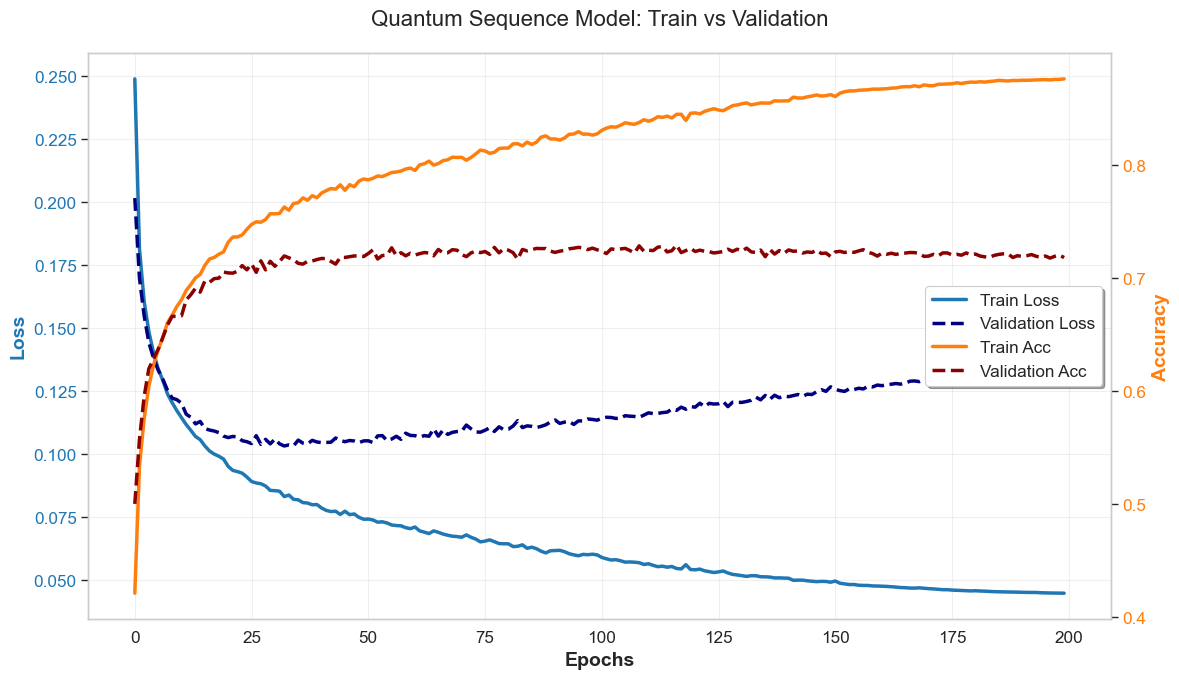

In [8]:
# Set the aesthetic style
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# Create figure and primary axis (Loss)
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Plot Loss (Left Axis) ---
color_train_loss = 'tab:blue'
color_val_loss = 'navy'

ax1.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', color=color_train_loss, fontsize=14, fontweight='bold')

# Train Loss (Solid)
line1 = ax1.plot(train_loss_hist, color=color_train_loss, linewidth=2.5, label='Train Loss')
# Val Loss (Dashed)
line2 = ax1.plot(val_loss_hist, color=color_val_loss, linewidth=2.5, linestyle='--', label='Validation Loss')


ax1.tick_params(axis='y', labelcolor=color_train_loss)
ax1.grid(True, alpha=0.3)

# --- Plot Accuracy (Right Axis) ---
ax2 = ax1.twinx()
color_train_acc = 'tab:orange'
color_val_acc = 'darkred'

ax2.set_ylabel('Accuracy', color=color_train_acc, fontsize=14, fontweight='bold')

# Train Accuracy (Solid)
line3 = ax2.plot(train_acc_hist, color=color_train_acc, linewidth=2.5, label='Train Acc')
# Val Accuracy (Dashed)
line4 = ax2.plot(val_acc_hist, color=color_val_acc, linewidth=2.5, linestyle='--', label='Validation Acc')

ax2.tick_params(axis='y', labelcolor=color_train_acc)
ax2.grid(False)

# --- Combined Legend ---
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', frameon=True, fancybox=True, shadow=True)

# Title and Layout
plt.title('Quantum Sequence Model: Train vs Validation', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## Final Test Phase: Unbiased Evaluation

This section performs the final evaluation of the optimized model on the **Test Set**, which has been completely withheld during the training and hyperparameter tuning phases.

In [9]:
# Load Best Model for Testing
ckpt_dir = "../data/params/"
with open(f"{ckpt_dir}/classical_params_{N_MOLECS}_{TIMESTAMP}_BEST.pkl", "rb") as f:
    best_params = pickle.load(f)

In [10]:
@jax.jit
def calculate_classical_nll_step(params, x_batch, prop_batch, y_target_indices):
    """
    Calculates the Negative Log-Likelihood (NLL) for a batch using the classical model.
    """
    # Initialize hidden state (carry)
    batch_size = x_batch.shape[0]
    carry = jnp.zeros((batch_size, HIDDEN_DIM))
    
    # 1. Forward Pass
    logits, _ = model.apply({'params': params}, x_batch, prop_batch, carry)
    
    # 2. Calculate NLL (Cross Entropy)
    vocab_size = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab_size)
    flat_targets = y_target_indices.reshape(-1)
    
    # Create one-hot targets
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    # Calculate Log-Softmax for numerical stability
    log_probs = jax.nn.log_softmax(flat_logits)
    
    # NLL = - sum( target * log_prob )
    per_token_nll = -jnp.sum(target_one_hot * log_probs, axis=-1)
    
    # 3. Mask Padding
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    
    # Return summed NLL and token count for averaging later
    return jnp.sum(per_token_nll * mask), jnp.sum(mask)

# --- 2. Execution Function ---
def get_classical_test_nll(params, test_x, test_props, Y_ind_test):
    """
    Computes average NLL per token over the Test Set.
    """
    total_nll = 0.0
    total_tokens = 0.0
    
    for i in range(0, len(test_x), BATCH_SIZE):
        # Slicing
        idx_end = min(i + BATCH_SIZE, len(test_x))
        batch_x = test_x[i:idx_end]
        batch_p = test_props[i:idx_end]
        batch_y = Y_ind_test[i:idx_end]
        
        if len(batch_x) == 0: continue
        
        # Calculate Batch NLL
        nll, toks = calculate_classical_nll_step(params, batch_x, batch_p, batch_y)
        
        total_nll += float(nll)
        total_tokens += float(toks)
        
    return total_nll / total_tokens


classical_test_nll = get_classical_test_nll(
    best_params, 
    X_bits_test, 
    Props_test, 
    Y_ind_test
)

print(f"Test Set Average NLL per token: {classical_test_nll:.4f}")

Test Set Average NLL per token: 0.8601


In [11]:
def calculate_validity(generated_smiles_list):
    """
    Calculates the percentage of generated sequences that are chemically valid.
    Returns the score and the list of valid RDKit molecules (as SMILES).
    """
    valid_smiles = []
    for smi in generated_smiles_list:
        # Basic check: string is not None or empty
        if not smi:
            continue
        
        # RDKit check: Can we parse it?
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
            
    if len(generated_smiles_list) == 0:
        return 0.0, []
        
    score = len(valid_smiles) / len(generated_smiles_list)
    return score, valid_smiles

def calculate_uniqueness(valid_smiles_list):
    """
    Calculates the percentage of unique molecules among the VALID ones.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    unique_smiles = set(valid_smiles_list)
    score = len(unique_smiles) / len(valid_smiles_list)
    return score

def calculate_novelty(valid_smiles_list, training_smiles_set):
    """
    Calculates the percentage of valid molecules that do NOT appear in the training set.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    # Count how many generated molecules are NOT in the training set
    novel_mols = [s for s in valid_smiles_list if s not in training_smiles_set]
    
    score = len(novel_mols) / len(valid_smiles_list)
    return score

def load_training_smiles_for_novelty(train_csv_path, alphabet):
    """
    Reads the Training CSV tokens and converts them back to SMILES 
    to build the reference set for Novelty.
    """
    print(f"Loading Training Data for Novelty check: {train_csv_path}")
    
    # Read as string to preserve "00101" format
    df = pd.read_csv(train_csv_path, dtype=str)
    
    training_smiles = set()
    
    # Get token columns
    token_cols = [c for c in df.columns if 'token_' in c]
    
    for _, row in df.iterrows():
        # Extract token bits
        tokens_bits = [row[col] for col in token_cols]
        
        mol_tokens = []
        for bit_str in tokens_bits:
            if pd.isna(bit_str) or bit_str == 'nan': 
                continue
            
            try:
                # Bit string -> Index -> Token
                idx = int(bit_str, 2)
                if idx < len(alphabet):
                    token = alphabet[idx]
                    if token == '<EOS>': break
                    mol_tokens.append(token)
            except ValueError:
                continue 
        
        # Decode SELFIES to SMILES
        try:
            smi = sf.decoder("".join(mol_tokens))
            if smi:
                training_smiles.add(smi)
        except:
            continue
            
    print(f"Found {len(training_smiles)} unique molecules in Training Set.")
    return training_smiles

In [12]:
TRAIN_CSV = f"../data/structured_data_selfies_{N_MOLECS}_train.csv"
train_smiles_set = load_training_smiles_for_novelty(TRAIN_CSV, ALPHABET)

Loading Training Data for Novelty check: ../data/structured_data_selfies_8000_train.csv
Found 5044 unique molecules in Training Set.


In [28]:
# --- 1. Load Best Parameters ---
ckpt_dir = "../data/params/"
with open(f"{ckpt_dir}/classical_params_{N_MOLECS}_{TIMESTAMP}_BEST.pkl", "rb") as f:
    best_params = pickle.load(f)

# --- 2. Generation Function (Corrected) ---
def generate_classical(props, params, temperature=0.7):
    # Initialize with <SOS>
    curr_token = jnp.array([[SOS_index]]) # Shape: (1, 1)
    carry = jnp.zeros((1, HIDDEN_DIM))   # Initial hidden state
    generated_indices = []
    
    # Prepare properties: (3,) -> (1, 3)
    props = jnp.expand_dims(props, 0) 
    
    # Pre-calculate Property Embedding (it's constant for the whole sequence)
    # Shape: (1, 32)
    p_emb = model.apply({'params': params}, props, method=lambda m, p: m.prop_encoder(p))
    
    key = jax.random.PRNGKey(int(time.time()*1000))

    for _ in range(MAX_LEN):
        key, subkey = jax.random.split(key)
        
        # 1. Embed Token: Shape (1, 1, 32)
        x_emb = model.apply({'params': params}, curr_token, method=lambda m, x: m.embed(x))
        
        # 2. Combine (The Fix!)
        # We expand p_emb to (1, 1, 32) so we can add it without losing the sequence dim
        rnn_in = x_emb + jnp.expand_dims(p_emb, 1) 
        
        # 3. Run Scanned RNN
        # Input MUST be (Batch, Length, Features) -> (1, 1, 32)
        carry, rnn_out = model.apply(
            {'params': params}, 
            carry, 
            rnn_in, 
            method=lambda m, c, x: m.rnn(c, x)
        )
        
        # 4. Predict Token
        # rnn_out shape: (1, 1, 128)
        logits = model.apply({'params': params}, rnn_out, method=lambda m, x: m.token_head(x))
        
        # Extract logits for the single step: (Vocab_Size,)
        next_logits = logits[0, 0, :]
        
        # 5. Sampling
        scaled_logits = next_logits / temperature
        probs = jax.nn.softmax(scaled_logits)
        
        # Sample next index
        next_idx = jax.random.choice(subkey, a=VOCABULARY_SIZE, p=probs)
        
        # Stop if EOS
        if next_idx == EOS_index:
            break
            
        generated_indices.append(int(next_idx))
        
        # Update input for next step
        curr_token = jnp.array([[next_idx]])

    return generated_indices

# --- 3. Evaluation Loop ---
print("Generating from Classical Model...")
gen_smiles = []
target_props_list = []

for i in range(len(Props_test)):
    # Generate
    indices = generate_classical(Props_test[i], best_params, temperature=0.9)
    
    # Indices -> SELFIES -> SMILES
    tokens = [ALPHABET[idx] for idx in indices]
    selfies = "".join(tokens)
    
    try:
        smi = sf.decoder(selfies)
        gen_smiles.append(smi)
    except:
        gen_smiles.append(None)
        
    target_props_list.append(Props_test[i])



Generating from Classical Model...


In [29]:
valid_score, valid_mols = calculate_validity(gen_smiles)
unique_score = calculate_uniqueness(valid_mols)
nov_score = calculate_novelty(valid_mols, train_smiles_set)

print(f"Number of generated samples: {len(gen_smiles)}")
print(f"Validity:   {valid_score:.2%}")
print(f"Uniqueness: {unique_score:.2%}")
print(f"Novelty:    {nov_score:.2%}")

Number of generated samples: 1139
Validity:   100.00%
Uniqueness: 99.65%
Novelty:    98.33%


In [30]:
print(gen_smiles)

['COC=CC=C1C(N)=CC(=O)C1=C', 'N1C=N[NH1]C(C2=CC=C[NH1]2)=C1', 'N=C(N)C(=O)NC1=NC=CS1N(C=O)N', 'NCCCCC(=O)C1=CN=CC=C1O', 'NS(=O)(=O)C1=CC=C2C(=C1)CNCC2', 'CC(C)N1C=NC2=C(N)N=CN=C2C1=O', 'CCOC(=O)CCN(N)C', 'O=C(O1)C[NH1]C(C2=CC=CC=C2)=N1', 'C1NCC=C2OC1CCC=CC=C(Cl)C=C2', 'C1C=CC=C1CNC(=O)NC', 'CC1CCCCNC2=CC=CC=C2CC1', 'CNCC=CC(OC)=CC=CC=CC(=O)O', 'OCOC=CC1=C(OP=O)COOC=C1', 'NCC12C=C[NH1]C2C(=O)C[NH1]C=CN=C1', 'NCCCC1C=CC(Cl)=CC(Cl)=C1Cl', 'CNC=NC(C=CCCNCC)=O', 'CNC(=O)N1C2=CC=CC=C2C(O)=C1Cl', 'CC1=CC=C(O2)N=C(C)N=CC2=N1', 'COC(=O)C(CO)C(=O)N1CCCCC1', 'NC(=O)C=CC1=CC=CC=C1', 'CNC1=N[NH1]N=C1C(=O)C', 'CC=CC(N)C(=O)P(=O)(O)C(C)O', 'OC=NC1=CC=C2C=C1NC3=NN=NC3C2=O', 'NC=NC1=CC=CC2=CC=CC=C12', 'O=S(=O)C1=NC2=CC=C(Cl)C=C2C1=O', 'O=C(O)C=C(CC(=O)C)CCNCC', 'CCCOC(=O)C(O)(C1C(C)C)CO1', 'NCN=NOC1(CCCCCCN)C(=O)OC1', 'CNC(=S)C=C1C=CC=CC1=NCO', 'C=NC1=CN=CC2=CC=CC=C21', 'NC(CO)C(O)C1=CC=C2C=CC=CC2=C1', 'O=C(O)C1=CC=CC=C1N=CC(CCl)C=O', 'O=C1[NH1]C2=CC=CC=C2C1O', 'C1NN=NC=CC21CC3NCC2C3=N', 'NC(=O)C1=CC=C

In [31]:
# --- 1. Setup De-normalization ---
def denormalize(norm_value, min_val, max_val, target_max=np.pi):
    return (norm_value * (max_val - min_val) / target_max) + min_val

# --- 2. Create Results DataFrame (from your lists) ---
results_df = pd.DataFrame({
    'Target_LogP': [float(p[0]) for p in target_props_list],
    'Target_QED': [float(p[1]) for p in target_props_list],
    'Target_MW':   [float(p[2]) for p in target_props_list],
    'Generated_SMILES': gen_smiles
})
results_df.to_csv(f"../generation/final_results_classical_{N_MOLECS}_{TIMESTAMP}.csv", index=False)
print("Saved generation results to CSV.")

# --- 3. Define Property Calculation Function ---
def calculate_generated_properties(df):
    actual_logp, actual_qed, actual_mw, valid_indices = [], [], [], []

    for idx, row in df.iterrows():
        smi = row['Generated_SMILES']
        if not smi: continue
        
        mol = Chem.MolFromSmiles(smi)
        if mol:
            actual_logp.append(Descriptors.MolLogP(mol))
            actual_qed.append(QED.qed(mol))
            actual_mw.append(Descriptors.ExactMolWt(mol))
            valid_indices.append(idx)
            
    return pd.DataFrame({
        'LogP': actual_logp, 'QED': actual_qed, 'MW': actual_mw, 'Source': 'Generated'
    }), valid_indices

# --- 4. Define Plotting Function ---
def plot_property_distributions(combined_df):
    sns.set_context("paper", font_scale=1.4)
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    properties = ['LogP', 'QED', 'MW']
    colors = {'Test Set (Ground Truth)': 'grey', 'Generated': 'tab:red'} # Red for Classical
    
    for i, prop in enumerate(properties):
        ax = axes[i]
        sns.kdeplot(
            data=combined_df, x=prop, hue='Source', fill=True, 
            common_norm=False, palette=colors, alpha=0.3, linewidth=2.5, ax=ax
        )
        ax.set_title(f'{prop} Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

Saved generation results to CSV.


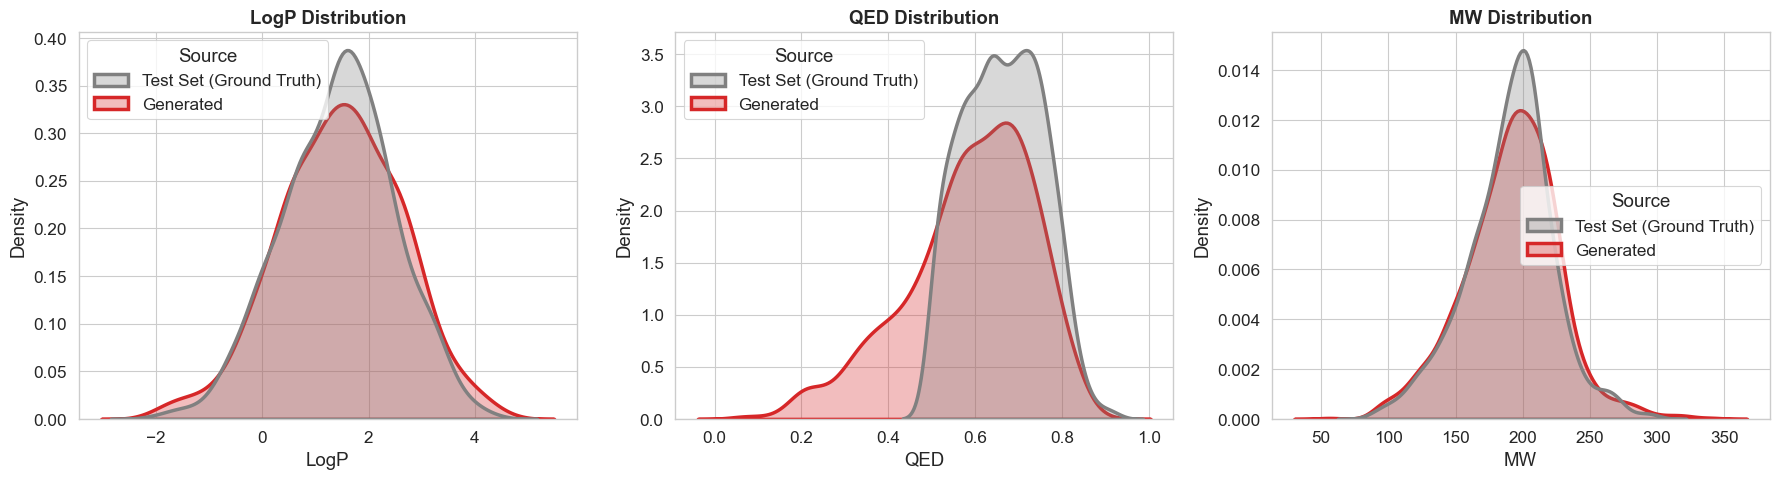

In [32]:
# 1. Calculate Properties of Generated Molecules
gen_props_df, valid_indices = calculate_generated_properties(results_df)

# 2. Prepare Ground Truth (Test Set Targets)
# We perform the De-normalization here to compare Real vs Real
test_props_df = results_df.loc[valid_indices, ['Target_LogP', 'Target_QED', 'Target_MW']].copy()
test_props_df['Target_LogP'] = test_props_df['Target_LogP'].apply(lambda x: denormalize(x, min_logp, max_logp))
test_props_df['Target_QED'] = test_props_df['Target_QED'].apply(lambda x: denormalize(x, min_qed, max_qed))
test_props_df['Target_MW'] = test_props_df['Target_MW'].apply(lambda x: denormalize(x, min_mw, max_mw))

test_props_df.columns = ['LogP', 'QED', 'MW']
test_props_df['Source'] = 'Test Set (Ground Truth)'

# 3. Combine
combined_df = pd.concat([test_props_df, gen_props_df], axis=0)

# 4. Plot
plot_property_distributions(combined_df)

Ranking molecules by Target-Match Accuracy...
Drawing top 9 most accurate generations...


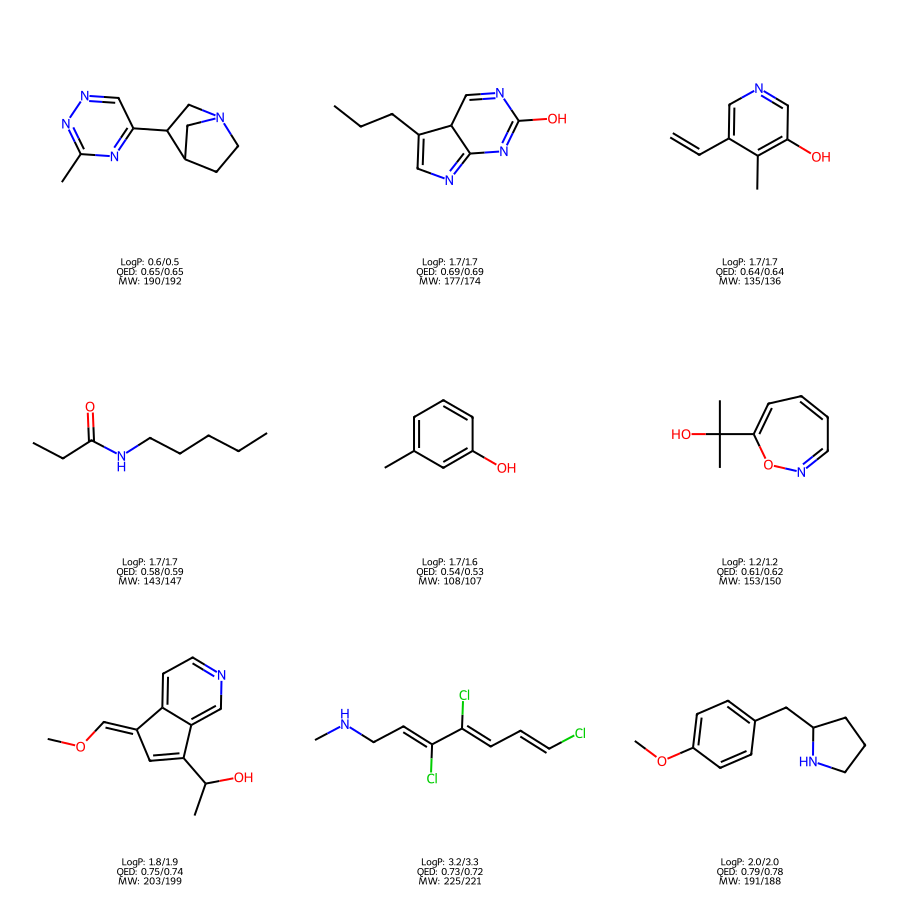

In [18]:
RESULTS_PATH = f"../generation/final_results_classical_{N_MOLECS}_{TIMESTAMP}.csv"
results_df = pd.read_csv(RESULTS_PATH)

print("Ranking molecules by Target-Match Accuracy...")

molecules_to_draw = []
errors = []

for idx, row in results_df.iterrows():
    smi = row['Generated_SMILES']
    if not smi or pd.isna(smi):
        continue
        
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        continue

    # A. Calculate Actual Properties
    act_logp = Descriptors.MolLogP(mol)
    act_qed = QED.qed(mol)
    act_mw = Descriptors.ExactMolWt(mol)
    
    # B. Get Target Properties (De-normalized)
    # Note: Ensure your CSV saved them as Normalized. 
    # If you saved de-normalized values already, skip the 'denorm' call.
    tgt_logp = denormalize(row['Target_LogP'], min_logp, max_logp)
    tgt_qed = denormalize(row['Target_QED'], min_qed, max_qed)
    tgt_mw = denormalize(row['Target_MW'], min_mw, max_mw)

    
    # C. Calculate Error (Mean Squared Error between Target and Actual)
    # We normalize the differences so MW doesn't dominate the error score
    # (e.g. MW error of 10 is small, but QED error of 10 is impossible)
    diff_logp = (act_logp - tgt_logp) ** 2
    diff_qed = (act_qed - tgt_qed) ** 2 * 100 # Scale up QED importance
    diff_mw = ((act_mw - tgt_mw) / 100) ** 2  # Scale down MW importance
    
    total_error = diff_logp + diff_qed + diff_mw
    
    molecules_to_draw.append({
        'mol': mol,
        'smiles': smi,
        'error': total_error,
        'legend': f"LogP: {act_logp:.1f}/{tgt_logp:.1f}\nQED: {act_qed:.2f}/{tgt_qed:.2f}\nMW: {act_mw:.0f}/{tgt_mw:.0f}"
    })

# --- 4. Sort and Select Top K ---
# Sort by lowest error (Best Match)
best_molecules = sorted(molecules_to_draw, key=lambda x: x['error'])[:9] # Top 9

# --- 5. Draw Grid ---
print(f"Drawing top {len(best_molecules)} most accurate generations...")

img = Draw.MolsToGridImage(
    [x['mol'] for x in best_molecules],
    molsPerRow=3,
    subImgSize=(300, 300),
    legends=[x['legend'] for x in best_molecules], # Shows Actual / Target
    returnPNG=False
)
# Display (if in notebook)
display(img)